## Setup

In [1]:
import tensorflow as tf
import numpy as np

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from util import import_dataset

address = '../../data/'
file_names = {}
file_names['images'] = 'full_data.npy'
file_names['subs'] = 'full_subredditlabels'
file_names['dict'] = 'full_subredditIndex'
file_names['nsfw'] = 'full_nsfwlabels'
data, dictionary = import_dataset(address, file_names)

In [3]:
print(data.X_train.shape)
print(data.X_val.shape)
print(data.X_test.shape)
print(data.y_train.shape)
print(data.y_val.shape)
print(data.y_test.shape)

(25450, 128, 128, 3)
(3181, 128, 128, 3)
(3182, 128, 128, 3)
(25450,)
(3181,)
(3182,)


## Run the Model

In [36]:
from googlenet import GoogleNet
from config import ModelConfig, TrainConfig

tf.reset_default_graph()

model_config = ModelConfig(eval_batch_size=3000, learning_rate=4.252e-4, output="subreddit", keep_prob=0.776)
train_config = TrainConfig(print_every=100, num_epochs=30, saver_address=r'../../saved_params/', \
    save_file_name = 'GoogleNet_subreddit_classification_4e-4_95_8', lr_decay=0.948)
model = GoogleNet(model_config)
sess = tf.Session()
model.train(data, sess, train_config)

---------------------------------------------------------
Batch 100/398 of epoch 1 finished in 18.368716 seconds
Batch 200/398 of epoch 1 finished in 17.772362 seconds
Batch 300/398 of epoch 1 finished in 17.760958 seconds
Epoch 1 training finished in 71.257335 seconds
train accuracy:38.1%
val accuracy:36.3%
Epoch 1 evaluation finished in 10.774495 seconds
---------------------------------------------------------
Batch 100/398 of epoch 2 finished in 17.767350 seconds
Batch 200/398 of epoch 2 finished in 17.720274 seconds
Batch 300/398 of epoch 2 finished in 17.676654 seconds
Epoch 2 training finished in 70.475116 seconds
train accuracy:49.4%
val accuracy:46.7%
Epoch 2 evaluation finished in 10.638122 seconds
---------------------------------------------------------
Batch 100/398 of epoch 3 finished in 17.704414 seconds
Batch 200/398 of epoch 3 finished in 17.679049 seconds
Batch 300/398 of epoch 3 finished in 17.659651 seconds
Epoch 3 training finished in 70.318110 seconds
train accura

## Load Model

In [4]:
from googlenet import GoogleNet
from config import ModelConfig, TrainConfig
import pickle

# Reset Graph
tf.reset_default_graph()

# Create model instance
model_config = ModelConfig()
model = GoogleNet(model_config)

# Load Saved Model
sess = tf.Session()
saver = tf.train.Saver()
file_name = "../../saved_params/GoogleNet_subreddit_classification_4e-4_95_8"
saver.restore(sess, file_name) 
saved_history = pickle.load(open(file_name + "_modelhist", 'rb'))
model.model_history = saved_history

# Test Model Accuracy
loss_train, acc_train = model.eval(data, sess, split='train')
loss_val, acc_val = model.eval(data, sess, split = 'val')

train accuracy:80.5%
val accuracy:58.7%


## Plot Graphs

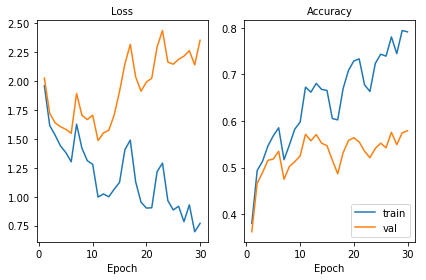

In [38]:
model.plot_loss_acc(data)

# Hyperparameter Tuning

In [29]:
import hyperopt as hpropt

def objective(args):
    model_config = ModelConfig(learning_rate=args['learning_rate'], keep_prob=args['keep_prob'], \
                               eval_batch_size=3000, output="subreddit")
    train_config = TrainConfig(num_epochs=args['num_epochs'], lr_decay=args['lr_decay'])
    
    tf.reset_default_graph()
    model = GoogleNet(model_config)
    
    sess = tf.Session()
    model.train(data, sess, train_config)
    cost = model.model_history.best_val_cost
    acc = model.model_history.best_val_acc
    
    saveList = {
        'accuracy_sbrd' : acc,
        'cost' : cost,
        'num_epochs' : args['num_epochs'],
        'learning_rate' : args['learning_rate'],
        'lr_decay' : args['lr_decay'],
        'keep_prob' : args['keep_prob']
    }
    print(saveList)
    pickle.dump(saveList, open("../../hprOpt/sbrd_" + str(acc) + ".dat", "wb"))
    model.plot_loss_acc(data)
    return cost

def optimize(space, max_evals=50):
    best = hpropt.fmin(objective, space, algo=hpropt.tpe.suggest, max_evals=max_evals)
    print(best)
    return best

---------------------------------------------------------
Batch 100/398 of epoch 1 finished in 18.961597 seconds
Batch 200/398 of epoch 1 finished in 18.332808 seconds
Batch 300/398 of epoch 1 finished in 18.297838 seconds
Epoch 1 training finished in 73.476600 seconds
train accuracy:38.2%
val accuracy:37.3%
Epoch 1 evaluation finished in 11.674420 seconds
---------------------------------------------------------
Batch 100/398 of epoch 2 finished in 18.288209 seconds
Batch 200/398 of epoch 2 finished in 18.213092 seconds
Batch 300/398 of epoch 2 finished in 18.269677 seconds
Epoch 2 training finished in 72.599374 seconds
train accuracy:48.3%
val accuracy:45.4%
Epoch 2 evaluation finished in 11.372008 seconds
---------------------------------------------------------
Batch 100/398 of epoch 3 finished in 18.268671 seconds
Batch 200/398 of epoch 3 finished in 18.250302 seconds
Batch 300/398 of epoch 3 finished in 18.271255 seconds
Epoch 3 training finished in 72.661616 seconds
train accura

KeyboardInterrupt: 

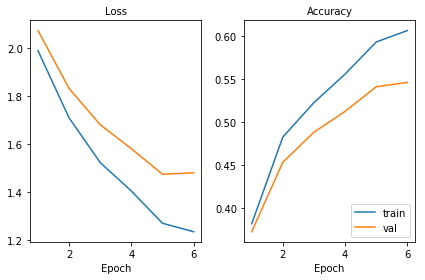

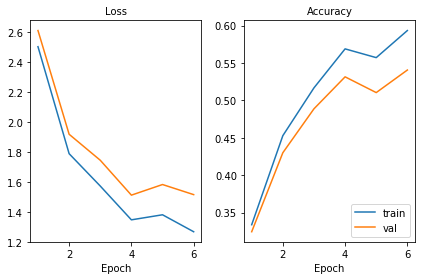

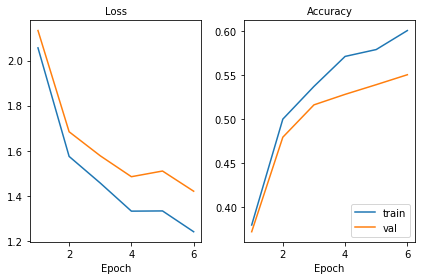

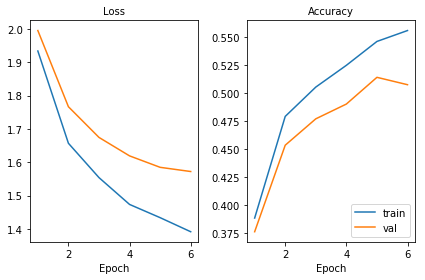

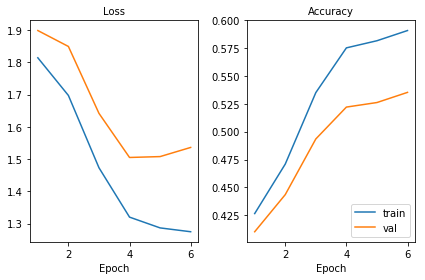

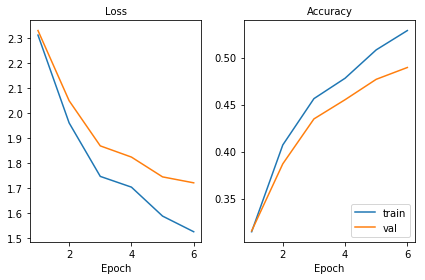

In [30]:
import math

def get_learning_rate_range(base_10_min, base_10_max):
    scale_factor = 1 / math.log10(math.e)
    return hpropt.hp.loguniform('learning_rate', scale_factor * base_10_min, scale_factor * base_10_max)

space = {
        'num_epochs' : 6,
        'learning_rate' : get_learning_rate_range(-4.5, -3),
        'lr_decay' : hpropt.hp.uniform('lr_decay', 0.9, 1.0),
        'keep_prob' : hpropt.hp.uniform('keep_prob', 0.6, 1.0)
}
best_opt = optimize(space, 30)

## Evaluate on Test Set

In [5]:
# Get model predictions
y_test_pred = sess.run(model.prediction, {model.X_placeholder: data.X_test, model.y_placeholder: data.y_test, 
                                            model.is_training_placeholder:False})

y_test_pred = np.argmax(y_test_pred, axis = 1)

Normalized confusion matrix


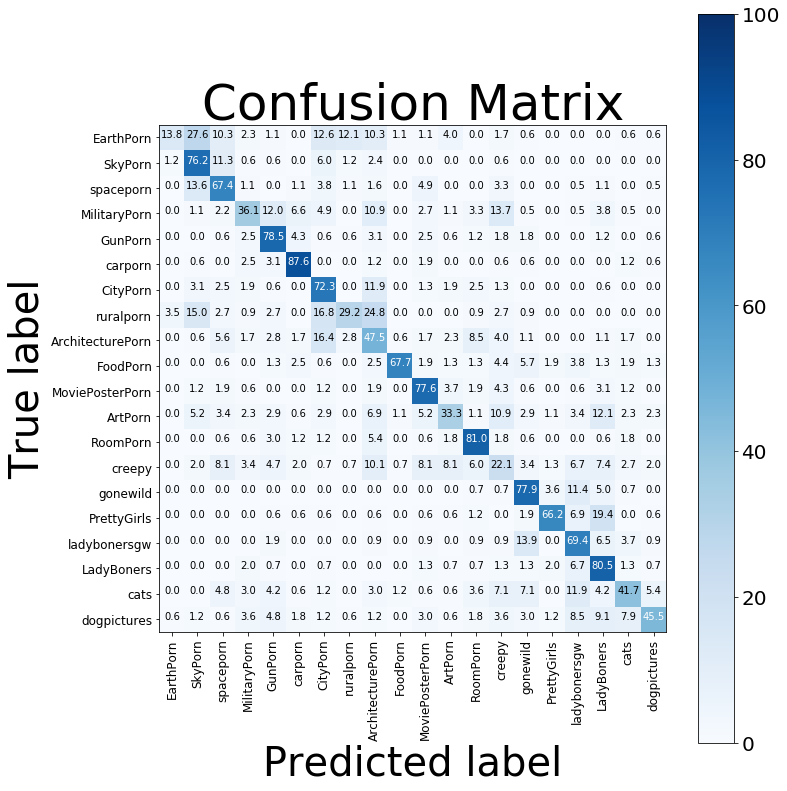

In [6]:
from util import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

classes = sorted(dictionary, key=dictionary.get)
cm = confusion_matrix(data.y_test, y_test_pred)
plot_confusion_matrix(cm, classes, normalize=True, task='subreddit')

Best hyperparameters:
* Learning rate: 0.0004251912188089649
* Keep prob: 0.7764128217492
* Learning rate decay: 0.9477267959340122

In [7]:
from util import get_f1_score

f1_score = get_f1_score(data.y_test, y_test_pred)
print(f1_score)

0.568568611295


In [8]:
_ = model.eval(data, sess, split="test")

test accuracy:58.4%
